In [205]:
import pandas as pd
import numpy as np
import torch
df_spectra = pd.read_csv('../../data/spectra.csv').T
print(df_spectra.shape)
df_spectra.reset_index(inplace=False)
df_spectra.columns = range(len(df_spectra.columns))
data_sp = df_spectra.values.astype(np.float64)
print(data_sp.shape)
data_scaled = data_sp / np.max(data_sp)
# Separate wavelengths and fluxes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `data` is your dataset with shape [17, 10001]
# wavelengths = data[:, 0]  # Shape: [17]
fluxes_sp = data_sp[:, 0:]  # Transpose to get shape [10000, 17]
print(fluxes_sp.shape)
# Prepare inputs for the model
df_photo = pd.read_csv('../../data/interpolated_spectra.csv').T
print(df_photo.shape)
df_photo.reset_index(inplace=False)
df_photo.columns = range(len(df_spectra.columns))
data_ph = df_photo.values.astype(np.float64)
print(data_ph.shape)
data_scaled_ph = data_ph / np.max(data_ph)
# Separate wavelengths and fluxes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `data` is your dataset with shape [17, 10001]
# wavelengths = data[:, 0]  # Shape: [17]
fluxes_ph = data_ph[:, 0:]  # Transpose to get shape [10000, 17]
print(fluxes_ph.shape)

(206, 10000)
(206, 10000)
(206, 10000)
(17, 10000)
(17, 10000)
(17, 10000)


In [206]:
import torch
import torch.nn as nn
import torch.optim as optim



In [207]:
class Generator(nn.Module):
    def __init__(self, input_dim=17, output_dim=206, hidden_dim=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)


In [208]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=206, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)


In [209]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class SpectraDataset(Dataset):
    def __init__(self, photometry_file, spectra_file):
        # Load data
        self.photometry = photometry_file  # Shape (10000, 17)
        self.spectra = spectra_file        # Shape (10000, 206)
        print(self.spectra.shape)
        # Convert to torch tensors
        self.photometry = torch.tensor(self.photometry, dtype=torch.float32)
        self.spectra = torch.tensor(self.spectra, dtype=torch.float32)
    
    def __len__(self):
        return len(self.photometry)
    
    def __getitem__(self, idx):
        return self.spectra[idx], self.photometry[idx]

# Initialize dataset and dataloader
dataset = SpectraDataset(data_ph.T, data_sp.T)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)


(10000, 206)


In [231]:
import torch
import torch.nn as nn
import torch.optim as optim

# Attention mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, hidden_states):
        attn_weights = torch.softmax(self.attn(hidden_states), dim=1)
        context_vector = torch.sum(attn_weights * hidden_states, dim=1)
        return context_vector

# Complex Generator
class ComplexGenerator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(ComplexGenerator, self).__init__()
        self.rnn = nn.LSTM(latent_dim + 1, hidden_dim, batch_first=True, num_layers=5, bidirectional=True, dropout=0.3)
        self.attn = nn.MultiheadAttention(hidden_dim * 2, num_heads=4, dropout=0.3)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.ln1 = nn.LayerNorm(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)
        self.residual_fc = nn.Sequential(
            nn.Linear(output_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        self.dropout = nn.Dropout(0.4)

    def forward(self, z, wavelengths):
        if wavelengths.dim() == 2:
            wavelengths = wavelengths.unsqueeze(-1)
        z = torch.cat([z, wavelengths], dim=-1)
        h, _ = self.rnn(z)
        h = h.permute(1, 0, 2)
        h_attn, _ = self.attn(h, h, h)
        h_attn = h_attn.permute(1, 0, 2)
        h = self.dropout(h_attn)
        h = torch.relu(self.fc1(h))
        h = torch.relu(self.ln1(self.fc2(h)))
        output = self.fc3(h)
        output = output + self.residual_fc(output)
        return output

# Complex Discriminator
class ComplexDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ComplexDiscriminator, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=5, dropout=0.3)
        self.attn = nn.MultiheadAttention(hidden_dim * 2, num_heads=4, dropout=0.3)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.ln1 = nn.LayerNorm(hidden_dim // 2)
        self.ln2 = nn.LayerNorm(hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, output_dim)
        self.residual_fc = nn.Sequential(
            nn.Linear(hidden_dim // 4, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 4)
        )

    def forward(self, x):
        h, _ = self.rnn(x)
        h = h.permute(1, 0, 2)
        h_attn, _ = self.attn(h, h, h)
        h_attn = h_attn.permute(1, 0, 2)
        h = self.dropout(h_attn.mean(dim=1))
        h = torch.relu(self.fc1(h))
        h = torch.relu(self.ln1(self.fc2(h)))
        h = torch.relu(self.ln2(self.fc3(h)))
        h = h + self.residual_fc(h)
        return torch.sigmoid(self.fc4(h))

# Embedding Network
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super(EmbeddingNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.latent = nn.Linear(hidden_dim, latent_dim)
        nn.init.xavier_uniform_(self.latent.weight)
        nn.init.zeros_(self.latent.bias)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return self.latent(x)

# Recovery Network
class RecoveryNetwork(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(RecoveryNetwork, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, output_dim, batch_first=True)

    def forward(self, h):
        h = self.fc(h).unsqueeze(1)
        output, _ = self.rnn(h.repeat(1, h.shape[1], 1))
        return output

# TimeGAN Class
class TimeGAN:
    def __init__(self, input_dim, hidden_dim, latent_dim, device):
        self.device = device
        self.embedding_net = EmbeddingNetwork(input_dim, hidden_dim, latent_dim).to(device)
        self.recovery_net = RecoveryNetwork(latent_dim, hidden_dim, input_dim).to(device)
        self.generator_net = ComplexGenerator(latent_dim, hidden_dim, 10000).to(device)
        self.discriminator_net = ComplexDiscriminator(10000, hidden_dim, 1).to(device)
        
        # Initialize optimizers for all components
        self.optim_emb = optim.Adam(self.embedding_net.parameters(), lr=0.001)
        self.optim_rec = optim.Adam(self.recovery_net.parameters(), lr=0.001)
        self.optim_gen = optim.Adam(self.generator_net.parameters(), lr=0.001)
        self.optim_disc = optim.Adam(self.discriminator_net.parameters(), lr=0.001)
        
        # Loss functions
        self.bce_loss = nn.BCELoss()
        self.mse_loss = nn.MSELoss()
        
    def train_step(self, real_data, wavelengths):
        batch_size = real_data.size(0)
        
        # === 1. Train Discriminator ===
        latent_vectors = torch.randn(batch_size, 10).to(self.device)
        generated_data = self.generator_net(latent_vectors, wavelengths)

        # Prepare real and fake labels
        real_labels = torch.ones(batch_size, 1).to(self.device)
        fake_labels = torch.zeros(batch_size, 1).to(self.device)

        # Compute discriminator loss
        self.optim_disc.zero_grad()
        real_loss = self.bce_loss(self.discriminator_net(real_data), real_labels)
        fake_loss = self.bce_loss(self.discriminator_net(generated_data.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        self.optim_disc.step()

        # === 2. Train Generator ===
        self.optim_gen.zero_grad()
        generated_data = self.generator_net(latent_vectors, wavelengths)
        g_loss = self.bce_loss(self.discriminator_net(generated_data), real_labels)
        g_loss.backward()
        self.optim_gen.step()

        return d_loss.item(), g_loss.item()

    def generate(self, latent_vectors, wavelengths):
        self.generator_net.eval()
        with torch.no_grad():
            generated_data = self.generator_net(latent_vectors, wavelengths)
        return generated_data

# Training Loop Example
num_epochs = 1000
input_dim = 17
hidden_dim = 128
latent_dim = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize TimeGAN
time_gan = TimeGAN(input_dim, hidden_dim, latent_dim, device)

# Assuming `real_data_loader` is a DataLoader
for epoch in range(num_epochs):
    for real_data, wavelengths in dataloader:
        real_data = real_data.to(device)
        wavelengths = wavelengths.to(device)

        # Run a training step
        d_loss, g_loss = time_gan.train_step(real_data, wavelengths)

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] Discriminator Loss: {d_loss:.4f}, Generator Loss: {g_loss:.4f}")

# Generate Sample Data
latent_vectors = torch.randn(10, latent_dim).to(device)
wavelengths = torch.linspace(0, 1, 10).unsqueeze(-1).repeat(10, 1).to(device)
generated_data = time_gan.generate(latent_vectors, wavelengths)
print(generated_data)


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

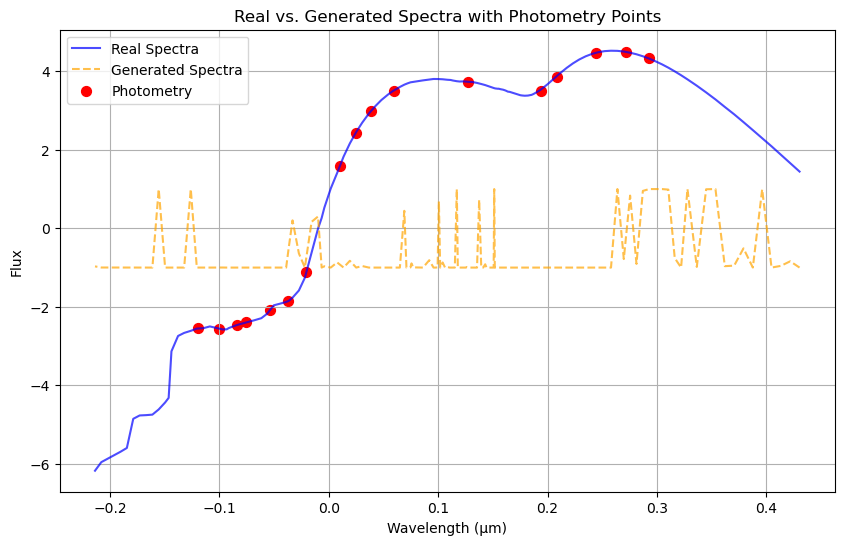

In [212]:
import matplotlib.pyplot as plt

def plot_spectra(real_spectra, photometry, generated_spectra, photometry_wavelengths, spectra_wavelengths, index=0):
    """
    Plots real spectra, photometry points, and generated spectra.
    
    Parameters:
        real_spectra (torch.Tensor): Real spectra data, shape [batch_size, 206]
        photometry (torch.Tensor): Photometry data, shape [batch_size, 17]
        generated_spectra (torch.Tensor): Generated spectra data, shape [batch_size, 206]
        photometry_wavelengths (list or array): Wavelengths corresponding to the photometry data (17 values)
        spectra_wavelengths (list or array): Wavelengths corresponding to the spectra data (206 values)
        index (int): Index of the sample in the batch to plot
    """
    # Convert tensors to numpy for plotting
    real_spectra = real_spectra.detach().cpu().numpy()[index]
    generated_spectra = generated_spectra.detach().cpu().numpy()[index]
    photometry = photometry.detach().cpu().numpy()[index]
    
    # Plotting the real spectra
    plt.figure(figsize=(10, 6))
    plt.plot(spectra_wavelengths, real_spectra, label='Real Spectra', color='blue', alpha=0.7)
    
    # Plotting the generated spectra
    plt.plot(spectra_wavelengths, generated_spectra, label='Generated Spectra', color='orange', linestyle='--', alpha=0.7)
    
    # Plotting the photometry points
    plt.scatter(photometry_wavelengths, photometry, label='Photometry', color='red', s=50)
    
    # Add labels and legend
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Flux')
    plt.title('Real vs. Generated Spectra with Photometry Points')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage after training
real_spectra, photometry_data = next(iter(dataloader))  # Get a batch of real spectra and photometry
real_spectra = real_spectra.to(device)
photometry_data = photometry_data.to(device)

# Generate spectra from the photometry data
generator.eval()  # Set the generator to evaluation mode
with torch.no_grad():
    generated_spectra = generator(photometry_data)


df = pd.read_csv('../../data/interpolated_spectra.csv').T

df.reset_index(inplace=True)
df.columns = range(len(df.columns))
data = df.values.astype(np.float64)
# data = data / data.values.max()

data_scaled = data / np.max(data)
dfspectr = pd.read_csv('../../data/spectra.csv').T

dfspectr.reset_index(inplace=True)
dfspectr.columns = range(len(dfspectr.columns))
dataspectr = dfspectr.values.astype(np.float64)
# data = data / data.values.max()

dataspectr = dataspectr / np.max(dataspectr)
# Separate wavelengths and fluxes
# wavelengths_spectra = dataspectr[:, 0]  # Shape: [17,]

# Define wavelengths for plotting (replace with actual wavelengths)
photometry_wavelengths = data_scaled[:, 0] # Example for 17 bands
spectra_wavelengths =  dataspectr[:, 0]  # Example for 206 points

# Plot the first sample in the batch
plot_spectra(real_spectra, photometry_data, generated_spectra, photometry_wavelengths, spectra_wavelengths, index=0)


# Diffusion Model


In [227]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Residual Block as depicted in the diagram
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.swish = Swish()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.swish(self.conv1(x))
        out = self.conv2(out)
        out += x  # Residual connection
        return self.relu(out)

# TSDiff Architecture based on the diagram
class TSDiff(nn.Module):
    def __init__(self, input_dim, time_steps=1000, num_blocks=5, d_model=64, nhead=4, num_encoder_layers=2):
        super(TSDiff, self).__init__()
        self.input_dim = input_dim
        self.time_steps = time_steps
        self.d_model = d_model

        # Noise schedule (beta values)
        self.betas = torch.linspace(0.0001, 0.02, time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

        # Initial Convolution Layer
        # Initial Convolution Layer
        self.initial_conv = nn.Conv1d(in_channels=17, out_channels=32, kernel_size=3, padding=1)

        # Linear layer to match d_model
        self.to_d_model = nn.Linear(32, d_model)

        # Stack of Residual Blocks
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(32, 32) for _ in range(num_blocks)
        ])

        # Transformer Layer
        self.transformer_layer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers)

        # Output Layer
        self.output_conv = nn.Conv1d(in_channels=d_model, out_channels=206, kernel_size=1)


    def forward_diffusion_sample(self, x0, t):
        noise = torch.randn_like(x0)
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def forward(self, x, t):
        x = self.initial_conv(x)
        for block in self.residual_blocks:
            x = block(x)

        # Project to d_model dimensions
        x = self.to_d_model(x.permute(0, 2, 1))  # [batch, seq_len, d_model]
        x = x.permute(1, 0, 2)  # [seq_len, batch, d_model]

        # Pass through the Transformer layer
        x = self.transformer_layer(x, x)
        x = x.permute(1, 2, 0)  # [batch, d_model, seq_len]

        # Output Convolution
        output = self.output_conv(x)

        # Reshape to match [batch_size, 206]
        output = output.squeeze(2)  # Squeeze the sequence length if it is 1 to match real_spectra
        return output


    def denoise(self, noisy_x, t):
        predicted_noise = self.forward(noisy_x, t)
        return predicted_noise

class SelfGuidedTSDiff(nn.Module):
    def __init__(self, input_dim, time_steps=1000):
        super(SelfGuidedTSDiff, self).__init__()
        self.ts_diff = TSDiff(input_dim=input_dim, time_steps=time_steps)

    def forward(self, xt, t, y_obs=None):
        eps_hat = self.ts_diff(xt, t)
        if y_obs is not None:
            grad = torch.autograd.grad(eps_hat, xt, grad_outputs=torch.ones_like(eps_hat), create_graph=True)[0]
            eps_hat = eps_hat + 0.1 * grad * (y_obs - eps_hat)
        return eps_hat

    def denoise(self, noisy_x, t):
        return self.ts_diff.denoise(noisy_x, t)

# Define a simple dataset for demonstration
class SpectraDataset(Dataset):
    def __init__(self, photometry_file, spectra_file):
        # Load data
        self.photometry = photometry_file.T# Shape (10000, 17)
        self.spectra = spectra_file.T        # Shape (10000, 206)
        
        # Convert to torch tensors
        self.photometry = torch.tensor(self.photometry, dtype=torch.float32)
        self.spectra = torch.tensor(self.spectra, dtype=torch.float32)
    
    def __len__(self):
        return len(self.photometry)
    
    def __getitem__(self, idx):
        return self.spectra[idx], self.photometry[idx]

# Initialize dataset and dataloader
photometry_file = '../../data/interpolated_spectra.csv'
spectra_file = '../../data/spectra.csv'
# dataset = SpectraDataset(photometry_file, spectra_file)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
dataset = SpectraDataset(data_ph, data_sp)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)
# Initialize Model, Optimizer, and Loss
input_dim = 17
time_steps = 1000
model = SelfGuidedTSDiff(input_dim=input_dim, time_steps=time_steps).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training Example
num_epochs = 100


for epoch in range(num_epochs):
    model.train()

    for i, (real_spectra, photometry_data) in enumerate(dataloader):
        real_spectra = real_spectra.to(device)
        photometry_data = photometry_data.to(device)
        # print(photometry_data.shape)
        # Randomly generate time steps for each sample in the batch
        t = torch.randint(0, time_steps, (real_spectra.size(0),)).to(device)

        # Reshape photometry data to be [batch_size, input_dim, seq_len]
        photometry_data = photometry_data.unsqueeze(2)  # Ensure [batch_size, 17, 1]

        # Forward pass
        output = model.forward(photometry_data, t)

        # Compute loss
        loss = criterion(output, real_spectra)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")



Epoch [1/100], Loss: 0.7909777164459229
Epoch [2/100], Loss: 0.2782862186431885
Epoch [3/100], Loss: 0.18429772555828094
Epoch [4/100], Loss: 0.11287540942430496
Epoch [5/100], Loss: 0.11646298319101334
Epoch [6/100], Loss: 0.09094982594251633
Epoch [7/100], Loss: 0.08934413641691208
Epoch [8/100], Loss: 0.08616411685943604
Epoch [9/100], Loss: 0.07079421728849411
Epoch [10/100], Loss: 0.06872349232435226
Epoch [11/100], Loss: 0.06008582562208176
Epoch [12/100], Loss: 0.06140100583434105
Epoch [13/100], Loss: 0.059350281953811646
Epoch [14/100], Loss: 0.053055670112371445
Epoch [15/100], Loss: 0.0637793093919754
Epoch [16/100], Loss: 0.05676989629864693
Epoch [17/100], Loss: 0.04179393872618675
Epoch [18/100], Loss: 0.04340984672307968
Epoch [19/100], Loss: 0.04797495901584625
Epoch [20/100], Loss: 0.0337858609855175
Epoch [21/100], Loss: 0.04220409691333771
Epoch [22/100], Loss: 0.042707666754722595
Epoch [23/100], Loss: 0.037951283156871796
Epoch [24/100], Loss: 0.04553363472223282
E

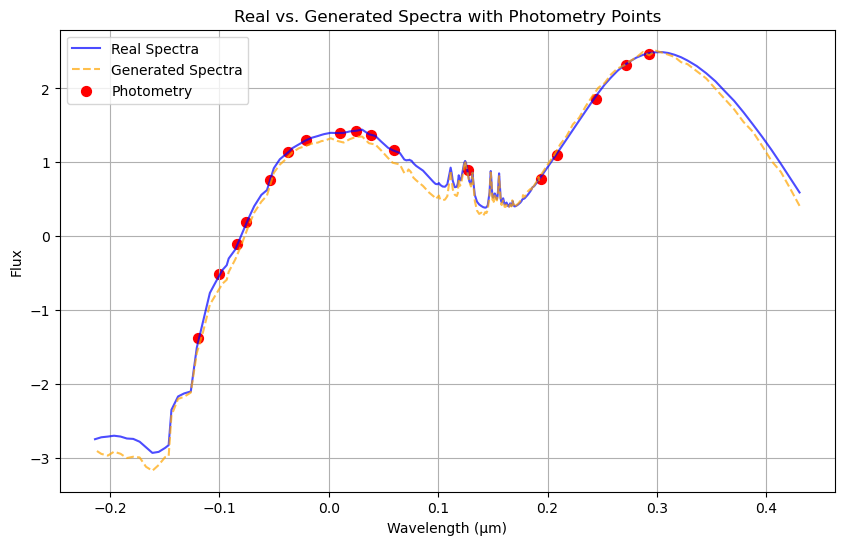

In [226]:

# Plotting Example
def plot_spectra(real_spectra, photometry, generated_spectra, photometry_wavelengths, spectra_wavelengths, index=0):
    # Convert tensors to numpy for plotting
    real_spectra = real_spectra.detach().cpu().numpy()[index]
    generated_spectra = generated_spectra.detach().cpu().numpy()[index]
    photometry = photometry.detach().cpu().numpy()[index]
    
    # Plotting the real spectra
    plt.figure(figsize=(10, 6))
    plt.plot(spectra_wavelengths, real_spectra, label='Real Spectra', color='blue', alpha=0.7)
    
    # Plotting the generated spectra
    plt.plot(spectra_wavelengths, generated_spectra, label='Generated Spectra', color='orange', linestyle='--', alpha=0.7)
    
    # Plotting the photometry points
    plt.scatter(photometry_wavelengths, photometry, label='Photometry', color='red', s=50)
    
    # Add labels and legend
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Flux')
    plt.title('Real vs. Generated Spectra with Photometry Points')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Plot Usage
real_spectra, photometry_data = next(iter(dataloader))
real_spectra = real_spectra.to(device)
photometry_data = photometry_data.unsqueeze(2).to(device)
with torch.no_grad():
    generated_spectra = model.forward(photometry_data, t)
data_scaled[:, 0]
dataspectr[:, 0]
# Define wavelengths for plotting
photometry_wavelengths = data_scaled[:, 0]  # Example for 17 bands
spectra_wavelengths = dataspectr[:, 0]  # Example for 206 points

plot_spectra(real_spectra, photometry_data, generated_spectra, photometry_wavelengths, spectra_wavelengths, index=0)


In [ ]:
torch.cuda.empty_cache()